Please go through Giba's post and kernel  to underrstand what this leak is all about
https://www.kaggle.com/titericz/the-property-by-giba (kernel)
https://www.kaggle.com/c/santander-value-prediction-challenge/discussion/61329 (post)

Also, go through this Jiazhen's kernel which finds more columns to exploit leak
https://www.kaggle.com/johnfarrell/giba-s-property-extended-result

I just exploit data property in brute force way and then fill in remaining by row non zero means! This should bring everyone on level-playing field.

**Let the competition begin! :D**

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from os.path import join

from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

from tqdm import tqdm, tqdm_notebook
tqdm.pandas(tqdm_notebook)
# Any results you write to the current directory are saved as output.

In [2]:
input_dir = join(os.getcwd())
train = pd.read_csv(join(input_dir, 'train.csv'))
test = pd.read_csv(join(input_dir, 'test.csv'))

In [3]:
transact_cols = [f for f in train.columns if f not in ["ID", "target"]]
y = np.log1p(train["target"]).values

In [4]:
test["target"] = train["target"].mean()

# get all leak columns

In [7]:
def _get_leak(df, cols, lag=0):
    d1 = df[cols[:-lag - 2]].apply(tuple, axis=1).to_frame().rename(columns={0: 'key'})
    d2 = df[cols[lag + 2:]].apply(tuple, axis=1).to_frame().rename(columns={0: 'key'})
    d2['pred'] = df[cols[lag]]
    d3 = d2[~d2.duplicated(['key'], keep=False)]
    return d1.merge(d3, how='left', on='key').pred.fillna(0)

def get_all_leak(cols=None, nlags=15):
    """
    We just recursively fetch target value for different lags
    """
    print('number of columns = {}'.format(len(cols)))
    print('used columns = {}'.format(cols))
    
    df = pd.concat([train[["ID", "target"] + cols], 
                    test[["ID", "target"] + cols]]).reset_index(drop=True)
    
    for i in tqdm_notebook(range(nlags)):
        df["leaked_target_"+str(i)] = _get_leak(df, cols, i)
        
    leaky_cols = ["leaked_target_{}".format(i) for i in range(nlags)]
    train_with_leaked = train.join(df.set_index("ID")[leaky_cols], on="ID", how="left")
    test_with_leaked = test.join(df.set_index("ID")[leaky_cols], on="ID", how="left")
    
    return train_with_leaked, test_with_leaked

We take time series columns from [here](https://www.kaggle.com/johnfarrell/giba-s-property-extended-result)

In [8]:
train_leak1, test_leak1 = get_all_leak(
    cols=['f190486d6', '58e2e02e6', 'eeb9cd3aa', '9fd594eec', '6eef030c1',
          '15ace8c9f', 'fb0f5dbfe', '58e056e12', '20aa07010', '024c577b9',
          'd6bb78916', 'b43a7cfd5', '58232a6fb', '1702b5bf0', '324921c7b', 
          '62e59a501', '2ec5b290f', '241f0f867', 'fb49e4212',  '66ace2992',
          'f74e8f13d', '5c6487af1', '963a49cdc', '26fc93eb7', '1931ccfdd', 
          '703885424', '70feb1494', '491b9ee45', '23310aa6f', 'e176a204a',
          '6619d81fc', '1db387535', 'fc99f9426', '91f701ba2',  '0572565c2',
          '190db8488',  'adb64ff71', 'c47340d97', 'c5a231d81', '0ff32eb98'], 
    nlags=25
)

number of columns = 40
used columns = ['f190486d6', '58e2e02e6', 'eeb9cd3aa', '9fd594eec', '6eef030c1', '15ace8c9f', 'fb0f5dbfe', '58e056e12', '20aa07010', '024c577b9', 'd6bb78916', 'b43a7cfd5', '58232a6fb', '1702b5bf0', '324921c7b', '62e59a501', '2ec5b290f', '241f0f867', 'fb49e4212', '66ace2992', 'f74e8f13d', '5c6487af1', '963a49cdc', '26fc93eb7', '1931ccfdd', '703885424', '70feb1494', '491b9ee45', '23310aa6f', 'e176a204a', '6619d81fc', '1db387535', 'fc99f9426', '91f701ba2', '0572565c2', '190db8488', 'adb64ff71', 'c47340d97', 'c5a231d81', '0ff32eb98']


HBox(children=(IntProgress(value=0, max=25), HTML(value='')))

In [9]:
pd.concat((train_leak1['target'], train_leak1.filter(regex='leaked_target', axis=1)), axis=1).head(10)

,target,leaked_target_0,leaked_target_1,leaked_target_2,leaked_target_3,leaked_target_4,leaked_target_5,leaked_target_6,leaked_target_7,leaked_target_8,...,leaked_target_15,leaked_target_16,leaked_target_17,leaked_target_18,leaked_target_19,leaked_target_20,leaked_target_21,leaked_target_22,leaked_target_23,leaked_target_24
0,38000000.0,38000000.0,38000000.0,38000000.0,0.0,38000000.0,0.0,38000000.0,0.0,0.0,...,0.0,0.0,38000000.0,0.0,38000000.0,0.0,0.0,0.0,0.0,0.0
1,600000.0,600000.0,0.0,0.0,0.0,0.0,0.0,600000.0,0.0,600000.0,...,600000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,14400000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2800000.0,0.0,0.0,0.0,2800000.0,0.0,0.0,0.0,2800000.0,0.0,...,2800000.0,0.0,0.0,0.0,2800000.0,0.0,2800000.0,2800000.0,0.0,0.0
6,164000.0,0.0,0.0,0.0,164000.0,0.0,164000.0,0.0,0.0,0.0,...,0.0,164000.0,0.0,0.0,164000.0,0.0,0.0,0.0,0.0,0.0
7,600000.0,600000.0,0.0,0.0,0.0,0.0,0.0,600000.0,0.0,0.0,...,600000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,600000.0,0.0
8,979000.0,979000.0,979000.0,979000.0,979000.0,979000.0,979000.0,0.0,0.0,0.0,...,979000.0,0.0,979000.0,979000.0,0.0,0.0,0.0,0.0,0.0,0.0
9,460000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,460000.0,0.0,...,0.0,0.0,0.0,0.0,0.0,460000.0,460000.0,0.0,0.0,0.0


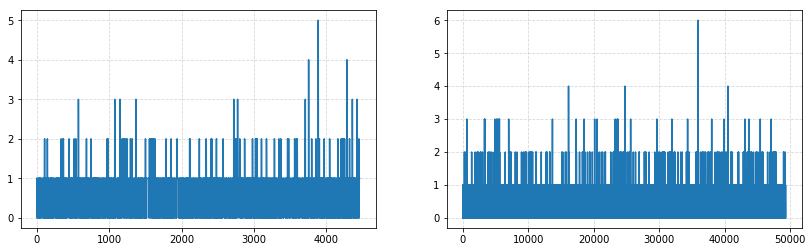

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
train_leak1.filter(regex='leaked_target', axis=1).where(lambda x: x != 0).nunique(axis=1).plot(ax=ax[0]);
test_leak1.filter(regex='leaked_target', axis=1).where(lambda x: x != 0).nunique(axis=1).plot(ax=ax[1]);

# complied leak

In [14]:
def append_compiled_leak(train, test):
    train["nonzero_mean"] = train[transact_cols].progress_apply(lambda x: np.expm1(np.log1p(x[x != 0]).mean()), axis=1)
    test["nonzero_mean"] = test[transact_cols].progress_apply(lambda x: np.expm1(np.log1p(x[x != 0]).mean()), axis=1)
    train["compiled_leak"] = 0
    test["compiled_leak"] = 0
    
    nlags = train.filter(regex='leaked_target', axis=1).shape[1]
    
    for i in tqdm_notebook(range(nlags)):
        train['compiled_leak'] = train['compiled_leak'].where(lambda x: x != 0, train['leaked_target_{}'.format(i)])
        test['compiled_leak'] = test['compiled_leak'].where(lambda x: x != 0, test['leaked_target_{}'.format(i)])
    
    print('Leak values found in train: {} columns, {}%'
      .format(sum(train["compiled_leak"] > 0), sum(train["compiled_leak"] > 0) / len(train) * 100))
    print('Leak values found in test: {} columns, {}%'
          .format(sum(test["compiled_leak"] > 0), sum(test["compiled_leak"] > 0) / len(test) * 100))
    print("% of correct leaks values in train {}"
          .format(sum(train["compiled_leak"] == train["target"]) / sum(train["compiled_leak"] > 0)))

    train['compiled_leak'] = train['compiled_leak'].where(lambda x: x != 0, train['nonzero_mean'])
    test['compiled_leak'] = test['compiled_leak'].where(lambda x: x != 0, test['nonzero_mean'])
    
    return train, test

In [15]:
train_leak1, test_leak1 = append_compiled_leak(train_leak1, test_leak1)

100%|██████████████████████████████████████████████████████████████████████████| 49342/49342 [00:34<00:00, 1410.27it/s]


HBox(children=(IntProgress(value=0, max=25), HTML(value='')))


Leak values found in train: 3577 columns, 80.21978021978022%
Leak values found in test: 7662 columns, 15.528353127153338%
% of correct leaks values in train 0.977914453452614


In [16]:
np.sqrt(mean_squared_error(y, np.log1p(train_leak1["compiled_leak"]).fillna(14.49)))

0.78830043228908975

# submit

In [18]:
#submission
sub = test_leak1[['ID', 'compiled_leak']].rename(columns={'compiled_leak': 'target'}).head()
sub.to_csv("baseline_submission_with_leaks.csv", index=False)